In [2]:
from importlib import reload
import numpy as np 
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
plt.ioff()
%matplotlib inline
import seaborn as sns
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, cophenet
from scipy.stats import ranksums
import gseapy
from gseapy.plot import barplot, dotplot
from numpy.linalg import eigh, eig
from sklearn.metrics.pairwise import euclidean_distances
from tqdm import tqdm
import time

import get_hic_map_of_selected_loci as hic

In [110]:
# Reload modules in case of modifications
reload(hic)

<module 'get_hic_map_of_selected_loci' from '/home/braunger/masterthesis/python_code/compare_hic/get_hic_map_of_selected_loci.py'>

## Load Hi-C data of selected loci

In [4]:
save_dir = '/home/braunger/masterthesis/save/'
fig_dir = '/home/braunger/masterthesis/save/figures/compare_hic/'
resol = 250000

In [100]:
selected_loci = pd.read_csv(save_dir+'pcst/DE_targets_loci.csv')
selected_loci.head()

,gene,net,locus,young_activity,old_activity,development
0,SCAMP3,young,chr_1_loc_155250000,young:active,old:active,young:active_old:active
1,LYL1,young,chr_19_loc_13000000,young:active,old:active,young:active_old:active
2,PPARGC1A,young,chr_4_loc_23750000,young:active,old:active,young:active_old:active
3,CHD4,young,chr_12_loc_6500000,young:active,old:active,young:active_old:active
4,FGF18,young,chr_5_loc_171250000,young:active,old:active,young:active_old:active


In [102]:
# Get Hi-C data for selected loci 
IMR90 = pd.read_csv(save_dir+'processed_hic_data/processed_hic_data_IMR90/final_BP250000_intraKR_interINTERKR/PCST_subset.csv', index_col = 0)
old_fibroblasts = pd.read_csv(save_dir+'processed_hic_data/processed_hic_data_old_fibroblasts/final_BP250000_intraKR_interINTERKR/PCST_subset.csv', index_col = 0)

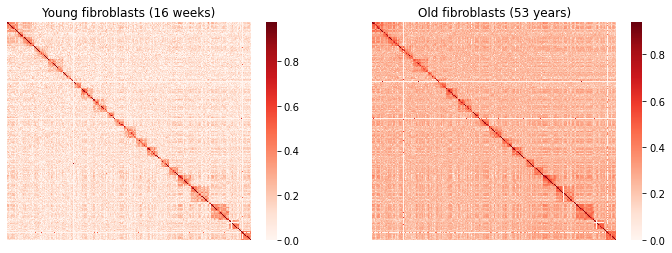

In [103]:
%matplotlib inline
fig, axs = plt.subplots(1, 2, figsize = (12, 4))
sns.heatmap(IMR90, cmap = "Reds", ax = axs[0], xticklabels=False, yticklabels=False)
axs[0].set_ylabel('') 
axs[0].set_title('Young fibroblasts (16 weeks)')

sns.heatmap(old_fibroblasts, cmap = "Reds", ax = axs[1], xticklabels=False, yticklabels=False)
axs[1].set_ylabel('') 
axs[1].set_title('Old fibroblasts (53 years)')
plt.show()

## Clustering IMR90

/home/braunger/miniconda3/envs/pcst/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 432x288 with 0 Axes>

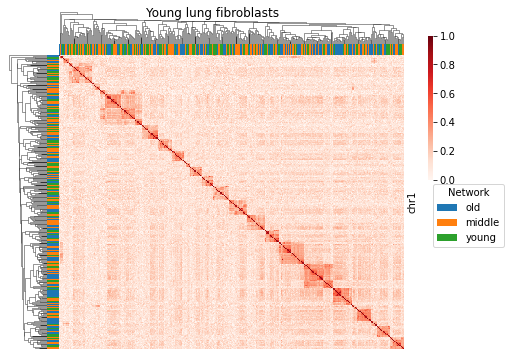

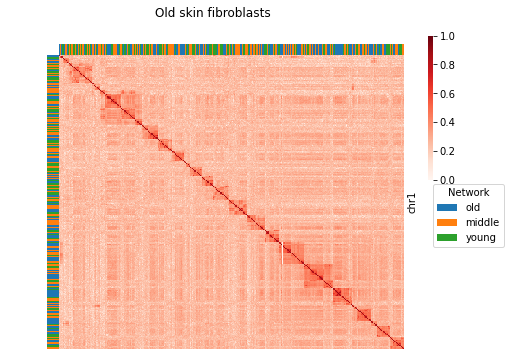

In [104]:
active_loci_IMR90 = set(selected_loci.loc[selected_loci['young_activity'] == 'young:active', 'locus']).intersection(IMR90.columns)
hic.plot_clusters_pairs(IMR90.loc[active_loci_IMR90, active_loci_IMR90], 'Young lung fibroblasts', 
                        old_fibroblasts.loc[active_loci_IMR90, active_loci_IMR90], 'Old skin fibroblasts', 
                        selected_loci)

## Clustering Old fibroblasts

<Figure size 432x288 with 0 Axes>

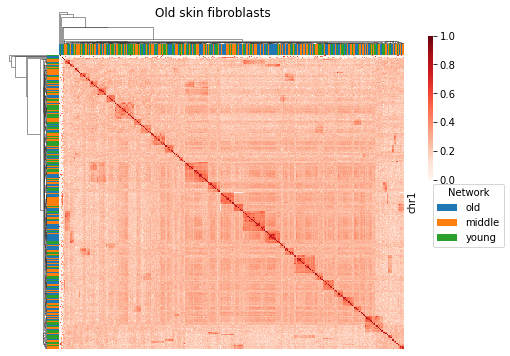

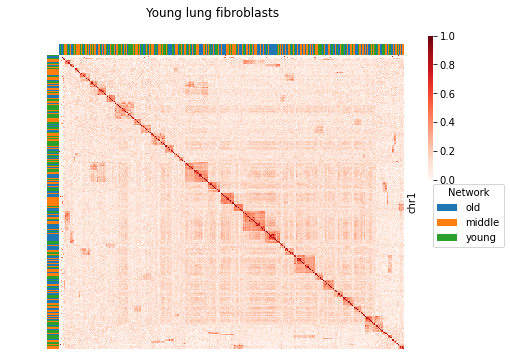

In [105]:
# create clustermap with annotation bar: old, middle, young
active_loci_old = set(selected_loci.loc[selected_loci['old_activity'] == 'old:active', 'locus']).intersection(old_fibroblasts.columns)
hic.plot_clusters_pairs(old_fibroblasts.loc[active_loci_old, active_loci_old], 'Old skin fibroblasts', 
                        IMR90.loc[active_loci_old, active_loci_old], 'Young lung fibroblasts', 
                        selected_loci)

## Histograms

In [111]:
# IMR90 to long format, join with selected_loci, filter for y-y, y-m, y-o, histogram
# only take interchrom values?

IMR90_long = hic.wide_to_long_anno(IMR90, selected_loci)
old_fibroblasts_long = hic.wide_to_long_anno(old_fibroblasts, selected_loci)

IMR90_long.head()

,chr1,chr2,value,gene_chr1,net_chr1,gene_chr2,net_chr2
0,chr_1_loc_750000,chr_1_loc_750000,0.945302,PLEKHN1,old,PLEKHN1,old
1,chr_1_loc_1000000,chr_1_loc_750000,0.828923,C1orf159,old,PLEKHN1,old
2,chr_1_loc_1250000,chr_1_loc_750000,0.718858,DVL1,old,PLEKHN1,old
3,chr_1_loc_1250000,chr_1_loc_750000,0.718858,ATAD3B,old,PLEKHN1,old
4,chr_1_loc_1500000,chr_1_loc_750000,0.599815,ATAD3A,old,PLEKHN1,old


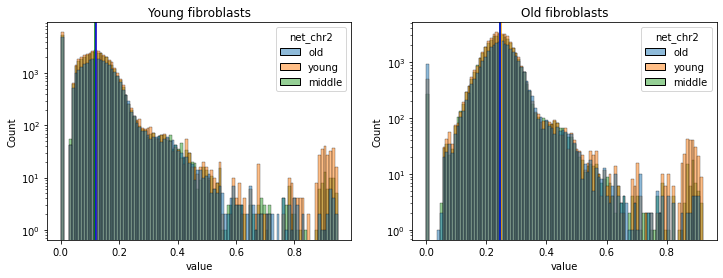

In [112]:
fig, axs = plt.subplots(1, 2, figsize = (12, 4))

sns.histplot(data=IMR90_long[IMR90_long['net_chr1'] == "young"], x="value", 
             hue="net_chr2", bins = 100,  ax = axs[0])
axs[0].axvline(x=IMR90_long.loc[(IMR90_long['net_chr1'] == "young") & (IMR90_long['net_chr2'] == "young"), 'value'].mean(), color='orange')
axs[0].axvline(x=IMR90_long.loc[(IMR90_long['net_chr1'] == "young") & (IMR90_long['net_chr2'] == "middle"), 'value'].mean(), color='green')
axs[0].axvline(x=IMR90_long.loc[(IMR90_long['net_chr1'] == "young") & (IMR90_long['net_chr2'] == "old"), 'value'].mean(), color='blue')
axs[0].set_title('Young fibroblasts')
axs[0].set_yscale('log')

sns.histplot(data=old_fibroblasts_long[old_fibroblasts_long['net_chr1'] == "young"], x="value", 
             hue="net_chr2", bins = 100, ax = axs[1])
axs[1].axvline(x=old_fibroblasts_long.loc[(old_fibroblasts_long['net_chr1'] == "young") & (old_fibroblasts_long['net_chr2'] == "young"), 'value'].mean(), color='orange')
axs[1].axvline(x=old_fibroblasts_long.loc[(old_fibroblasts_long['net_chr1'] == "young") & (old_fibroblasts_long['net_chr2'] == "middle"), 'value'].mean(), color='green')
axs[1].axvline(x=old_fibroblasts_long.loc[(old_fibroblasts_long['net_chr1'] == "young") & (old_fibroblasts_long['net_chr2'] == "old"), 'value'].mean(), color='blue')
axs[1].set_title('Old fibroblasts')
axs[1].set_yscale('log')

plt.show()

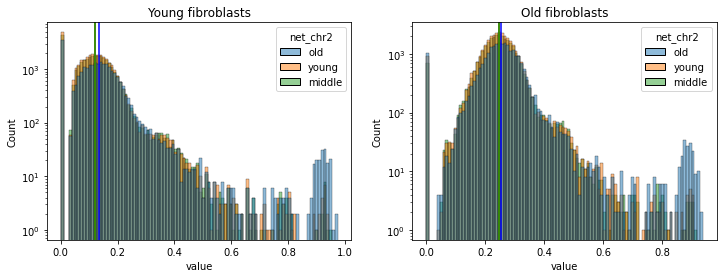

In [113]:
fig, axs = plt.subplots(1, 2, figsize = (12, 4))

sns.histplot(data=IMR90_long[IMR90_long['net_chr1'] == "old"], x="value", 
             hue="net_chr2", bins = 100,  ax = axs[0])
axs[0].axvline(x=IMR90_long.loc[(IMR90_long['net_chr1'] == "old") & (IMR90_long['net_chr2'] == "young"), 'value'].mean(), color='orange')
axs[0].axvline(x=IMR90_long.loc[(IMR90_long['net_chr1'] == "old") & (IMR90_long['net_chr2'] == "middle"), 'value'].mean(), color='green')
axs[0].axvline(x=IMR90_long.loc[(IMR90_long['net_chr1'] == "old") & (IMR90_long['net_chr2'] == "old"), 'value'].mean(), color='blue')
axs[0].set_title('Young fibroblasts')
axs[0].set_yscale('log')

sns.histplot(data=old_fibroblasts_long[old_fibroblasts_long['net_chr1'] == "old"], x="value", 
             hue="net_chr2", bins = 100, ax = axs[1])
axs[1].axvline(x=old_fibroblasts_long.loc[(old_fibroblasts_long['net_chr1'] == "old") & (old_fibroblasts_long['net_chr2'] == "young"), 'value'].mean(), color='orange')
axs[1].axvline(x=old_fibroblasts_long.loc[(old_fibroblasts_long['net_chr1'] == "old") & (old_fibroblasts_long['net_chr2'] == "middle"), 'value'].mean(), color='green')
axs[1].axvline(x=old_fibroblasts_long.loc[(old_fibroblasts_long['net_chr1'] == "old") & (old_fibroblasts_long['net_chr2'] == "old"), 'value'].mean(), color='blue')
axs[1].set_title('Old fibroblasts')
axs[1].set_yscale('log')

plt.show()